# Compute MSD in Python quickly with FFT

The implementation is entirely copied from this SO answer : http://stackoverflow.com/questions/34222272/computing-mean-square-displacement-using-python-and-fft#34222273

Thanks to [thomasfermi](http://stackoverflow.com/users/2609987/thomasfermi).

This notebook compares the speed of calculation of MSD with FFT and without with trackpy.

In [2]:
%load_ext snakeviz
%load_ext autoreload
%autoreload 2
%matplotlib inline

import timeit

import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

import numpy as np
import pandas as pd

import trackpy as tp

In [3]:
def autocorr_fft(x):
    N = len(x)
    F = np.fft.fft(x, n=2 * N)  # 2*N because of zero-padding
    PSD = F * F.conjugate()
    res = np.fft.ifft(PSD)
    res= (res[:N]).real  # now we have the autocorrelation in convention B
    n = N * np.ones(N) - np.arange(0, N) #divide res(m) by (N-m)
    return res / n  # this is the autocorrelation in convention A

def msd_fft(traj, mpp, fps, max_lagtime=100, detail=False, pos_columns=['x', 'y']):
    """Implementation comes from here : 
    http://stackoverflow.com/questions/34222272/computing-mean-square-displacement-using-python-and-fft#34222273
    """
    
    r = traj[pos_columns].values
    r *= mpp
    
    t = traj['frame']

    max_lagtime = min(max_lagtime, len(t))  # checking to be safe
    lagtimes = 1 + np.arange(max_lagtime - 1)    

    N = len(r)

    D = np.square(r).sum(axis=1) 
    D = np.append(D, 0)
    S2 = sum([autocorr_fft(r[:, i]) for i in range(len(pos_columns))])

    Q = 2 * D.sum()
    S1 = np.zeros(N)

    for m in range(N):
        Q = Q - D[m - 1] - D[N - m]
        S1[m] = Q / (N - m)

    msd = S1 - 2 * S2
    
    # This is not optimal but still faster
    # See the SO question
    msd = msd[1:max_lagtime]

    lagt = lagtimes / fps

    results = pd.DataFrame(np.array([msd, lagt]).T, columns=['msd', 'lagt'])
    results.index = 1 + np.arange(max_lagtime - 1)
    results.index.name = 'lagt'
    
    return results

def get(N, pos_columns):
    traj = np.cumsum(np.random.choice([-1., 0., 1.], size=(N, len(pos_columns))), axis=0)
    traj = pd.DataFrame(traj, columns=pos_columns)
    traj['frame'] = np.arange(N)
    return traj

In [4]:
# Generate a random trajectory

pos_columns = ['x', 'y', 'z']
mpp = 0.3
fps = 1
max_lagtime = 100

traj = get(N=10000, pos_columns=pos_columns)

In [5]:
# Get MSD with trackpy
msd1 = tp.msd(traj, mpp=mpp, fps=fps, max_lagtime=max_lagtime, pos_columns=pos_columns)
msd1[['msd', 'lagt']].head()

,msd,lagt
lagt,,
1,0.180216,1
2,0.359325,2
3,0.539730,3
4,0.720387,4
5,0.902917,5


In [6]:
# Get MSD with msd_fft
msd2 = msd_fft(traj, mpp=mpp, fps=fps, max_lagtime=max_lagtime, pos_columns=pos_columns)
msd2[['msd', 'lagt']].head()

,msd,lagt
lagt,,
1,0.180216,1
2,0.359325,2
3,0.539730,3
4,0.720387,4
5,0.902917,5


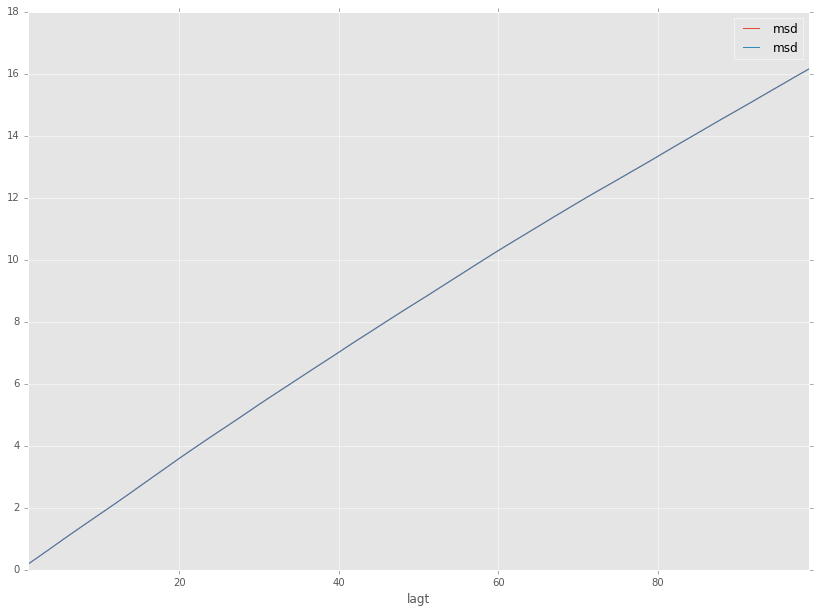

In [ ]:
# Compate MSD with plots
fig, ax = plt.subplots(figsize=(14, 10))

msd1.plot(x='lagt', y='msd', ax=ax)
msd2.plot(x='lagt', y='msd', ax=ax)

In [ ]:
t1 = %timeit -o tp.msd(traj, mpp=mpp, fps=fps, max_lagtime=max_lagtime, pos_columns=pos_columns)

In [ ]:
t2 = %timeit -o msd_fft(traj, mpp=mpp, fps=fps, max_lagtime=max_lagtime, pos_columns=pos_columns)